In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

### Helper Functions

In [2]:
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error 
from sklearn.metrics import mean_absolute_error
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

from sklearn import neighbors

In [3]:
def plot_monthly_rmse(y_test, y_pred, title=None):
    results = pd.DataFrame({"Measured": y_test, "Predicted": pd.Series(y_pred, index=y_test.index)})
    monthly_rmse = pd.Series()
    for month in range(12):
        test_month = results[results.index.month == (month+1)]
        monthly_rmse.loc[month+1] = root_mean_squared_error(test_month['Measured'],test_month['Predicted'])
    sns.barplot(monthly_rmse)
    plt.title(title)

In [4]:
def plot_monthly_mae(y_test, y_pred, title=None, export=None):
    results = pd.DataFrame({"Measured": y_test, "Predicted": pd.Series(y_pred, index=y_test.index)})
    monthly_mae = pd.Series()
    for month in range(12):
        test_month = results[results.index.month == (month+1)]
        monthly_mae.loc[month+1] = mean_absolute_error(test_month['Measured'],test_month['Predicted'])
    sns.barplot(monthly_mae)
    if title:
        plt.title(f"{title} Mean Absolute Error")
    plt.ylabel("Mean Absolute Error (kWh)", fontsize=14)
    plt.xlabel(f"Month", fontsize=14)
    plt.tight_layout()
    if export:
        plt.savefig(f"../figures/{export}.pdf")

In [5]:
def summary(y_test, y_pred, title=None, export=None):
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f} kWh")
    print(f"RMSE: {root_mean_squared_error(y_test,y_pred):.4f} kWh")
    results = pd.DataFrame({"Measured": y_test, "Predicted": pd.Series(y_pred, index=y_test.index)})
    plt.figure(figsize=(8,8))
    ax = sns.scatterplot(results, x="Measured", y="Predicted")
    plt.plot([0, results.max().min()], [0,results.max().min()], linewidth=2, color='r')
    # plt.title(title)
    # plt.figure(figsize=(16,8))
    # plot_monthly_rmse(y_test, y_pred, title=title)
    # plt.title(title)
    plt.figure(figsize=(8,4))
    plot_monthly_mae(y_test, y_pred, title=title, export=export)

In [6]:
def plot_monthly_avg(y_test, y_pred):
    results = pd.DataFrame({"Measured": y_test, "Predicted": pd.Series(y_pred, index=y_test.index)})
    monthly_rmse = pd.Series()
    for month in range(12):
        test_month = results[results.index.month == (month+1)]
        monthly_rmse.loc[month+1] = test_month['Measured'].mean()
    sns.barplot(monthly_rmse)

In [7]:
def monthly_train_and_predict(df, method, params, target_var='out.electricity.total.energy_consumption', title=None, export=None):
    results = pd.DataFrame()
    monthly_rmse = pd.Series()
    for month in range(1,13):
        train = df[df.month != month]
        test = df[df.month == month]

        x_train = train.drop(target_var, axis=1)
        y_train = train[target_var]

        x_test = test.drop(target_var, axis = 1)
        y_test = test[target_var]

        # Create the model with the passed method
        model = method(**params)
        # Train the model
        model.fit(x_train, y_train)

        # Generate the predictions
        y_pred = model.predict(x_test)

        # Set minimum value
        y_pred[y_pred < y_train.min()] = y_train.min()

        # Create a DF with both predictions and measure data
        month_results = pd.DataFrame({"Measured": y_test, "Predicted": pd.Series(y_pred, index=y_test.index)})

        # Get the RMSE for just this month
        monthly_rmse.loc[month] = root_mean_squared_error(month_results['Measured'],month_results['Predicted'])

        results = pd.concat([results, month_results])

    summary(results['Measured'], results['Predicted'], title=None, export=export)
    return results

## Load Data 
Load data and set up additional variables

In [8]:
weather = pd.read_csv("../Project_data/Normalized Data/noaa_sunnyvale_weather_hourly_2018.csv", index_col=0, parse_dates=True)
load = pd.read_csv("../Project_data/Normalized Data/sunnyvale_bid_367272_load_hourly_2018.csv", index_col=0, parse_dates=True)

In [9]:
# Make a copy of the dataframe to which to add addtional predictors
df = load.copy()

In [10]:
# Add temperature difference from 17C based on divergent behavior seen
df['temp_from_17'] = abs(weather['temperature'] - 17)

In [11]:
# Add Date Information
df['month'] =                   pd.to_numeric(load.index.strftime('%-m'))
df['day'] =                     pd.to_numeric(load.index.strftime("%-d"))
df['day_of_week'] =             pd.to_numeric(load.index.strftime("%w"))
df['day_of_year'] =             load.index.dayofyear
df['hour'] =                    pd.to_numeric(load.index.strftime("%-H"))

In [12]:
# Add Weekend/Weekday flag
df.loc[df['day_of_week'] < 5, "Weekday"] = 1
df.loc[df['day_of_week'] < 5, "Weekend"] = 0
df.loc[df['day_of_week'] >= 5, "Weekday"] = 0
df.loc[df['day_of_week'] >= 5, "Weekend"] = 1

In [13]:
# Add load from previous week
df['last_week_load'] = load['out.electricity.total.energy_consumption'].shift(periods=7, freq="D")

# Add load from previous Weekend/Weekday
df.loc[df["Weekday"] == 1, "previous_category_day_load"] = df.loc[df["Weekday"] == 1, "out.electricity.total.energy_consumption"].shift(24)
df.loc[df["Weekend"] == 1, "previous_category_day_load"] = df.loc[df["Weekend"] == 1, "out.electricity.total.energy_consumption"].shift(24)

In [14]:
# Trim off the first week (don't have data for previous week) and last entry
df = df.iloc[24*7:-1]

In [15]:
# Output Load Predictor File
df.to_csv("../Project_data/Predictor Data/load.csv")

## Split training and test data

In [16]:
# train , test = train_test_split(df, test_size = 1)
train = df.copy()
test = df.copy()

x_train = train.drop('out.electricity.total.energy_consumption', axis=1)
y_train = train['out.electricity.total.energy_consumption']

x_test = test.drop('out.electricity.total.energy_consumption', axis = 1)
y_test = test['out.electricity.total.energy_consumption']

# K Nearest Neighbors

In [17]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':range(2,30)}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5, scoring=mae_scorer)
model.fit(x_train,y_train)
model.best_params_

{'n_neighbors': 16}

MAE: 0.648 kWh
RMSE: 1.0035 kWh


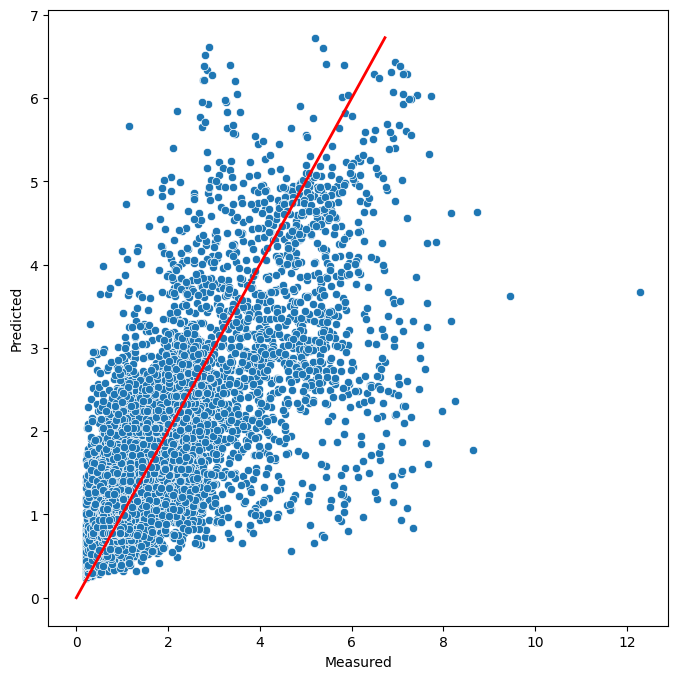

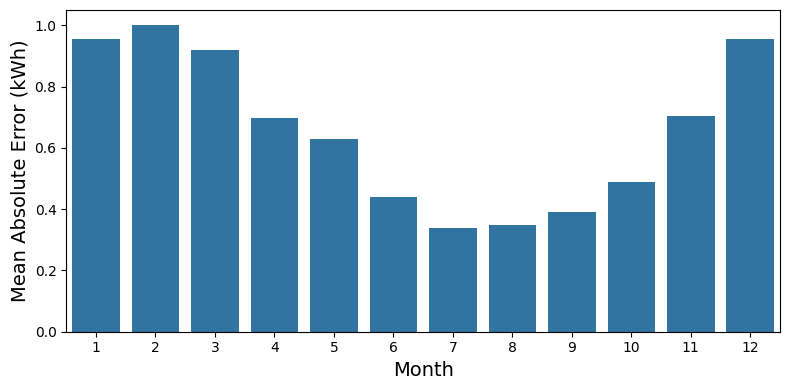

In [18]:
knn_results = monthly_train_and_predict(df, neighbors.KNeighborsRegressor, model.best_params_)

# Artificial Neural Network

In [19]:
import sklearn.neural_network 
max_iterations=1000

In [20]:
param_grid = [
        {
            'activation' : ['tanh', 'relu'],
            'hidden_layer_sizes': [(i, j) for i in range(10,20) for j in range(10,20)],
            "max_iter": [max_iterations]
        }
       ]

ann = GridSearchCV(sklearn.neural_network.MLPRegressor(), param_grid, cv=5, scoring=mae_scorer, n_jobs=-1)
ann.fit(x_train,y_train)

print("Best parameters set found on development set:")
print(ann.best_params_)

Best parameters set found on development set:
{'activation': 'relu', 'hidden_layer_sizes': (13, 18), 'max_iter': 1000}


MAE: 0.628 kWh
RMSE: 0.9867 kWh


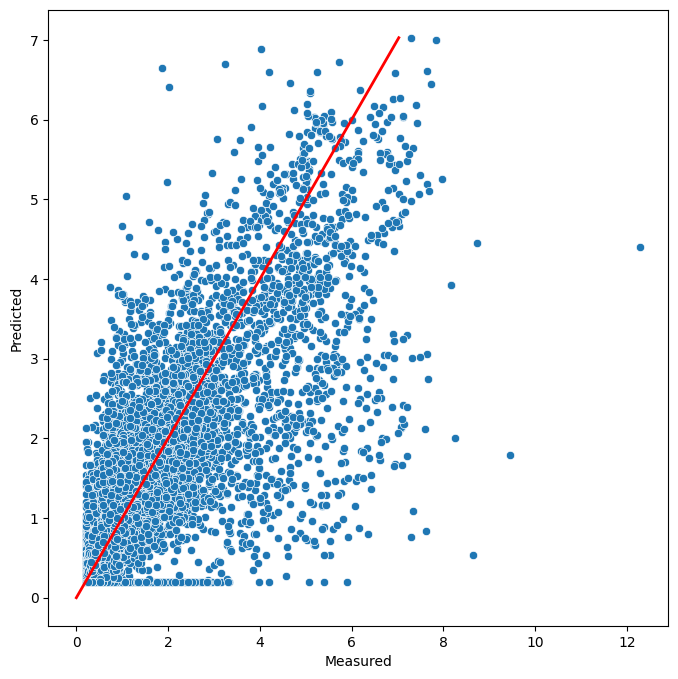

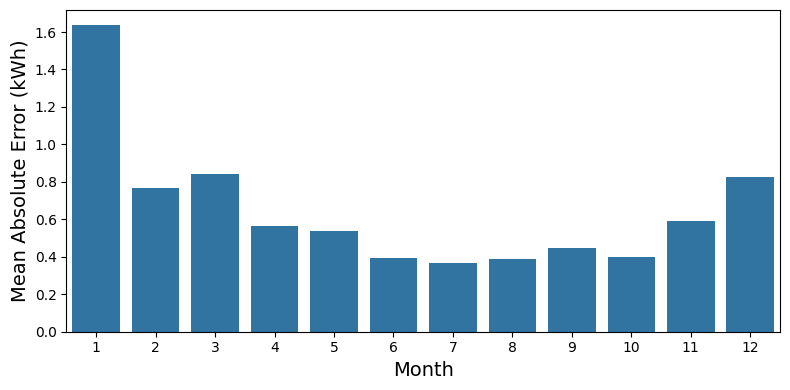

In [21]:
ann_results = monthly_train_and_predict(df, sklearn.neural_network.MLPRegressor, ann.best_params_)

# Support Vector Machine

In [22]:
import sklearn.svm

param_grid = [
    {
        'kernel': ['linear'], 
        'gamma': [1e-4, 1e-3, 0.01, "scale"],
        'C': [1, 10, 100, 1000, 10000]
    }
]

svr = GridSearchCV(sklearn.svm.SVR(), param_grid, cv=5, scoring=mae_scorer, n_jobs=-1)
svr.fit(x_train,y_train)

print("Best parameters set found on training set:")
print(svr.best_params_)

Best parameters set found on training set:
{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}


MAE: 0.532 kWh
RMSE: 0.8939 kWh


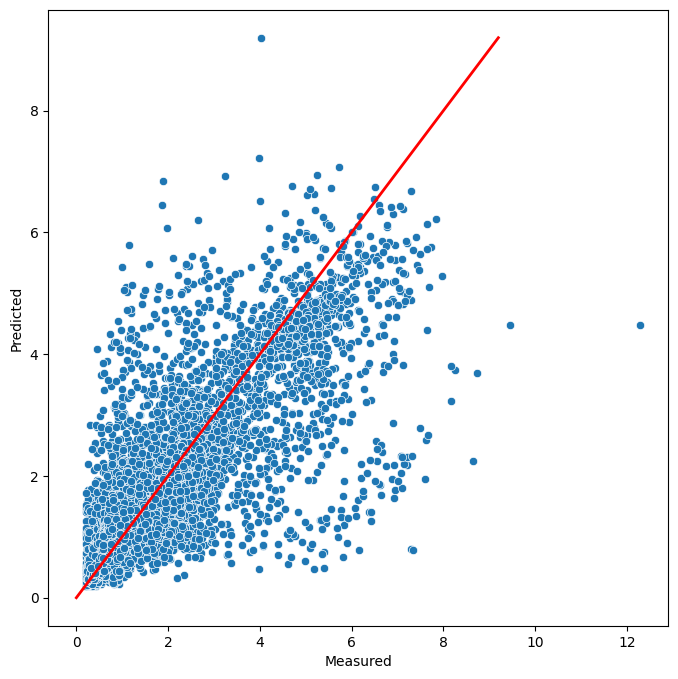

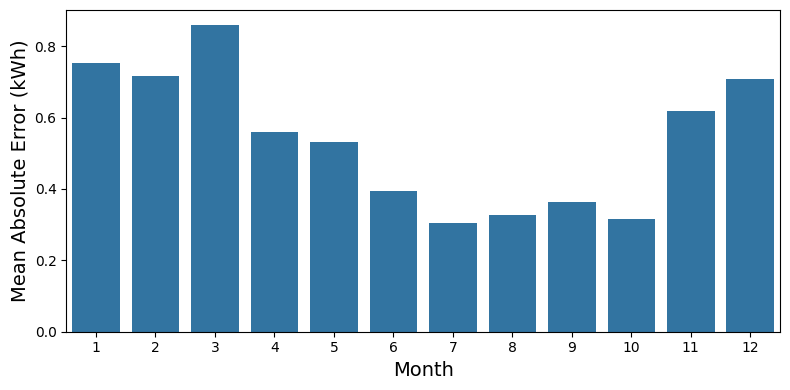

In [23]:
svr_results = monthly_train_and_predict(df, sklearn.svm.SVR, svr.best_params_, export="Load SVR Montly MAE")

# Results

In [24]:
print(f"KNN: {mean_absolute_error(knn_results['Measured'], knn_results['Predicted']):.3f}kWh")
print(f"ANN: {mean_absolute_error(ann_results['Measured'], ann_results['Predicted']):.3f}kWh")
print(f"SVR: {mean_absolute_error(svr_results['Measured'], svr_results['Predicted']):.3f}kWh")

KNN: 0.648kWh
ANN: 0.628kWh
SVR: 0.532kWh


# ARIMA

/Users/dandrusch/.pyenv/versions/3.10.6/envs/ds785/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/dandrusch/.pyenv/versions/3.10.6/envs/ds785/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/dandrusch/.pyenv/versions/3.10.6/envs/ds785/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                          SARIMAX Results                                           
Dep. Variable:     out.electricity.total.energy_consumption   No. Observations:                 8760
Model:                                      ARIMA(24, 1, 0)   Log Likelihood               -8153.008
Date:                                      Sat, 27 Apr 2024   AIC                          16356.015
Time:                                              11:08:15   BIC                          16532.961
Sample:                                          01-01-2018   HQIC                         16416.307
                                               - 12-31-2018                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2303      0.005  

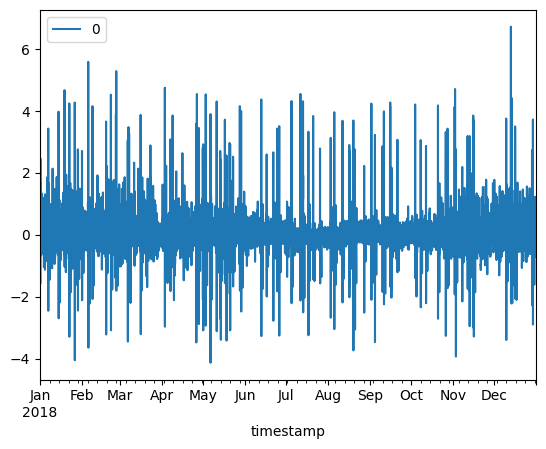

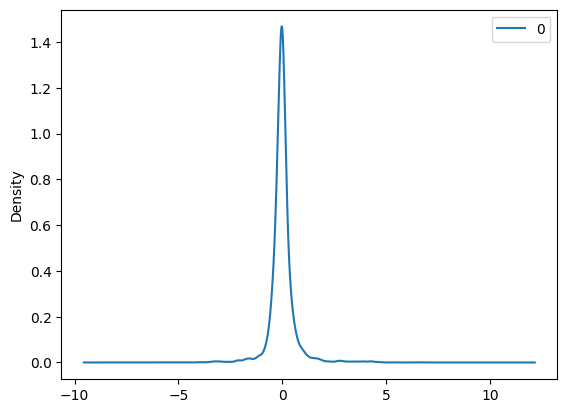

                 0
count  8760.000000
mean      0.000859
std       0.614128
min      -4.130091
25%      -0.208305
50%      -0.028754
75%       0.146180
max       6.720265


In [25]:
# fit an ARIMA model and plot residual errors
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

series = load['out.electricity.total.energy_consumption'].copy()
# series.index = series.index.to_period('M')
# fit model
model = ARIMA(series, order=(24,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [26]:
# split into train and test sets
month_trailing = series.iloc[:24*33]
X = month_trailing.values
size = int(len(X) - 48)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(24,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = mean_absolute_error(test, predictions)

predicted=1.360496, expected=0.797000
predicted=0.716509, expected=0.470000
predicted=0.612075, expected=0.425000
predicted=0.837757, expected=0.807000
predicted=1.241594, expected=1.253000
predicted=2.985132, expected=3.846000
predicted=4.597267, expected=3.832000
predicted=4.025712, expected=3.722000
predicted=4.008797, expected=3.939000
predicted=4.053793, expected=4.220000
predicted=4.519416, expected=4.733000
predicted=4.021905, expected=3.928000
predicted=2.789034, expected=2.926000
predicted=1.865396, expected=1.758000
predicted=1.590669, expected=1.003000
predicted=1.305962, expected=0.996000
predicted=0.732515, expected=0.776000
predicted=0.504273, expected=0.816000
predicted=1.137942, expected=0.930000
predicted=1.136672, expected=0.889000
predicted=2.628602, expected=2.417000
predicted=2.913116, expected=1.670000
predicted=0.371880, expected=1.431000
predicted=1.208433, expected=1.221000
predicted=1.201115, expected=0.921000
predicted=0.773259, expected=0.606000
predicted=0.

In [27]:
# split into train and test sets

mae = pd.Series()
y_test = []
y_pred = []
for day in range(330):
    offset = day*24
    month_trailing = series.iloc[offset:offset+24*33]
    X = month_trailing.values
    size = int(len(X) - 48)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    # walk-forward validation
    model = ARIMA(history, order=(24,1,0))
    model_fit = model.fit()
    predictions = model_fit.forecast(48)
    # evaluate forecasts
    mae[day] = mean_absolute_error(test, predictions)
    y_test.extend(test)
    y_pred.extend(predictions)

/Users/dandrusch/.pyenv/versions/3.10.6/envs/ds785/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dandrusch/.pyenv/versions/3.10.6/envs/ds785/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dandrusch/.pyenv/versions/3.10.6/envs/ds785/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dandrusch/.pyenv/versions/3.10.6/envs/ds785/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

In [28]:
mean_absolute_error(y_test, y_pred)

0.5782000425283627

<Axes: >

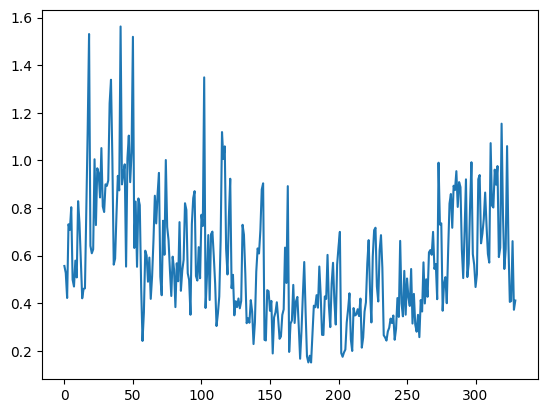

In [29]:
mae.plot()

0.8984651165485509


<Axes: xlabel='Measured (kWh)', ylabel='Predicted (kWh)'>

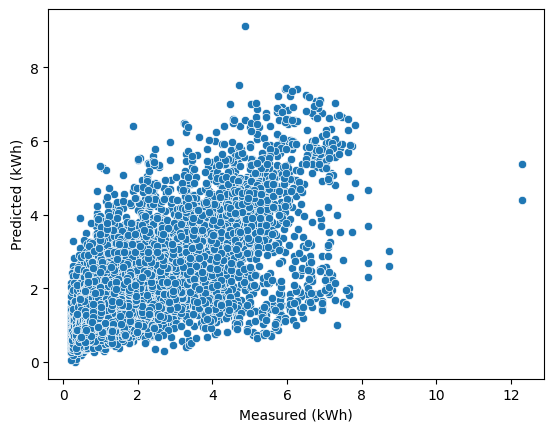

In [30]:
y_test = pd.Series(y_test)
results = pd.DataFrame({"Measured (kWh)": y_test, "Predicted (kWh)": pd.Series(y_pred, index=y_test.index)})
print(root_mean_squared_error(y_test, y_pred))
sns.scatterplot(results, x="Measured (kWh)", y="Predicted (kWh)")